In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [34]:
import os

import matplotlib.pyplot as plt
import nussl
from nussl.separation.base import DeepMixin
from nussl.separation.deep import DeepMaskEstimation
from nussl.evaluation import BSSEvalScale

import pipeline


def get_model(model_key):
    path = os.path.join(
        pipeline.constants.checkpoint_dir, model_key,
        "checkpoints", "latest.model.pth"
    )
    deepmixin = DeepMixin()
    deepmixin.load_model(path, device='cuda:0')
    return deepmixin

def visualize_and_embed(sources, label=None):
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='linear', db_cutoff=-40, alpha_amount=2.0)
    if label:
        plt.title(label)
    plt.show()
    nussl.play_utils.multitrack(sources)
    
def evaluate(item, estimates):
    evaluator = nussl.evaluation.BSSEvalScale(
            list(item['sources'].values()), estimates,
            compute_permutation=True,
            source_labels=list(item['sources'].keys())
        )

    scores = evaluator.evaluate()
    for key, score_dict in scores.items():
        if key in {'permutation', 'combination'}:
            continue
        else:
            scores[key] = score_dict["SI-SDR"]
    return scores

# Results in deep clustering transfer learning
We pretrain on the following datasets:
 - MUSDB18 (sources: \[other, drums, vocals, bass\])
 - Slakh (sources: \[piano+guitar, drums\])
 - MUSDB18 + Slakh (sources: \[piano+guitar, drums, bass\])

For each of these pretraineding datasets, we either apply no augmentations, apply a random pitch shift between -3 and 3 semitones, apply a random time stretch of a factor between .8 and 1.2, or incoherently mix the sources. 
 
Our downstream tasks is separating sources in the following datasets:
 - Bach10 (sources: \[saxophone, clarinet, bassoon, violin\], dataset length: 5 minutes)
 - Incoherent Remixpacks - Drumset (sources: \[Cymbal+Hi-Hat, Kick Drum, Snare, Toms\], dataset length: 18 minutes, when silence is removed.)
 - Dagstuhl ChoirSet (sources: \[Male, Female\], dataset length: 55 minutes)

### This notebook specifically shows the difference between the control model and the finetuned model. 
See results here: https://docs.google.com/spreadsheets/d/1ZWxxZmDjWqPK9RsZ8w3cEOTZpk94jYDuMJ3_j3PPdos/edit#gid=0

## Downstream 1: Dagstuhl ChoirSet
Control SI-SDR: `3.51 +/- 2.30` 

Best Experimental SI-SDR: `5.12 +/- 2.46`

In [2]:
## Get our dataset. 

dagstuhl_dataset = pipeline.dataset_prep.get_onthefly_dataset(
    "../ChoirSet/DagstuhlChoirSet/coherent_16k/test", "CoherentMixing",
    training=False,
    groupings={
        "male": ["Tenor", "Bass"],
        "female": ["Soprano", "Alto"]
    },
    mix_length=5,
    source_types = ["Tenor", "Bass", "Soprano", "Alto"]
)

In [3]:
## Load our models
experimental_key = "dagstuhl mask(2)"
control_key = "dagstuhl control(2)"
item = dagstuhl_dataset[0]

dagstuhl_exp_sep = DeepMaskEstimation(item["mix"])
dagstuhl_control_sep = DeepMaskEstimation(item["mix"])
dagstuhl_exp_sep.__dict__.update(get_model(experimental_key).__dict__)
dagstuhl_control_sep.__dict__.update(get_model(control_key).__dict__)

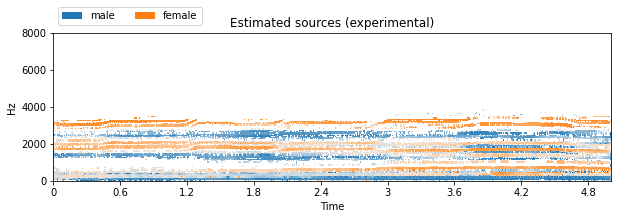


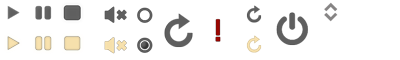
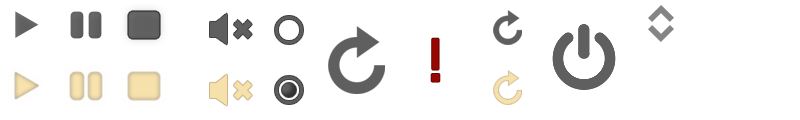
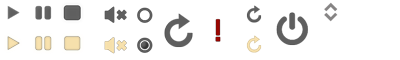

{'combination': (0, 1), 'permutation': (1, 0), 'female': [3.3032527565956116], 'male': [3.802465498447418]}


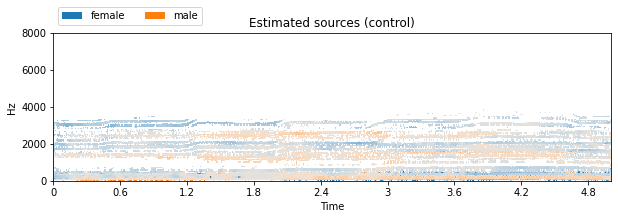


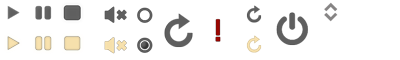
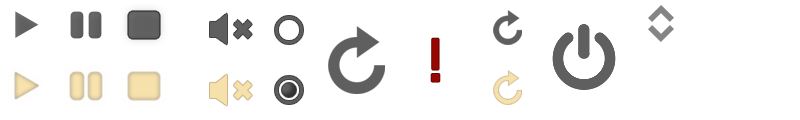
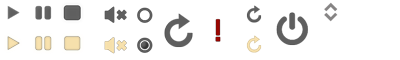

{'combination': (0, 1), 'permutation': (1, 0), 'female': [1.0614993423223495], 'male': [2.5140580534934998]}


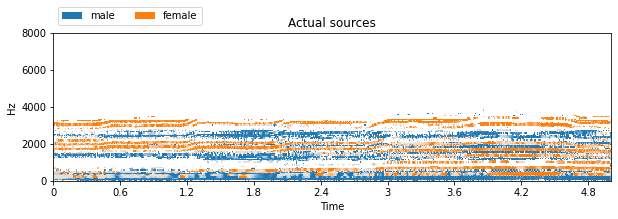


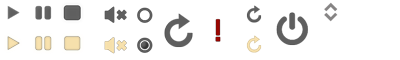
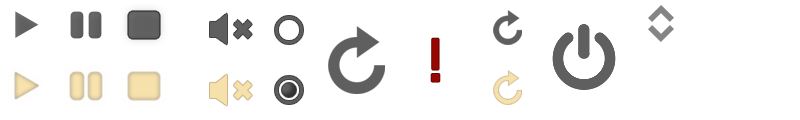
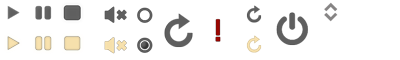

In [19]:
item = dagstuhl_dataset[0]
source_keys = sorted(item["sources"].keys())
exp_ests = dagstuhl_exp_sep(audio_signal=item["mix"])
control_ests = dagstuhl_control_sep(audio_signal=item["mix"])
visualize_and_embed({s: est for s, est in zip(source_keys, exp_ests)},
                    label="Estimated sources (experimental)")
print(evaluate(item, exp_ests))
visualize_and_embed({s: est for s, est in zip(source_keys, control_ests)},
                    label="Estimated sources (control)")
print(evaluate(item, control_ests))
visualize_and_embed(item["sources"], label="Actual sources")

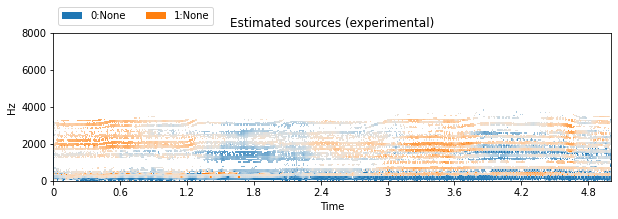


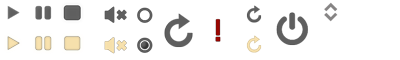
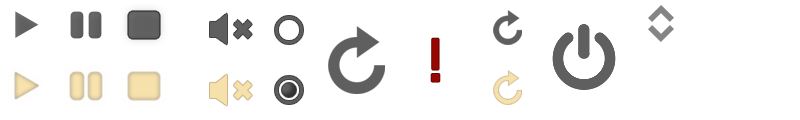
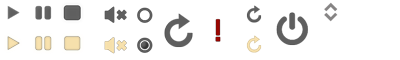

In [20]:
# For Dagstuhl, the best model was one trained on only the mask head.
# As a sanity check, we should see what happens
# if we train the mask head of the pretrained model with pretrained data.
# https://www.comet.ml/abugler/dpcl-transfer/4cca5449761c4619baa704cc4eb744e2

musdb_mask = DeepMaskEstimation(item["mix"])
musdb_mask.__dict__.update(get_model('musdb_mask').__dict__)
ests = musdb_mask(audio_signal=item["mix"])
visualize_and_embed(ests, label="Estimated sources (experimental)")

## Downstream 2: Drums from Remixpacks

Control SI-SDR: `2.17 +/- 12.51 `


Best Experimental SI-SDR: `3.51 +/- 12.63`

In [23]:
## Get our dataset. 

drumset_dataset = pipeline.dataset_prep.get_onthefly_dataset(
    "../fine_16k/test", "IncoherentMixing",
    training=False,
    groupings={
        "Cymbals": ["Cymbal", "Hi-hat"],
    },
    mix_length=10,
    source_types = ["Kick_drum", "Hi-hat", "Cymbal", "Snare_drum", "Toms"],
    silence_metadata = "../fine_16kmd/test"
)

[============================================================] 100.0% ...Scanning file from folder ../fine_16k/test/Kick_drum
Audio file ../fine_16k/test/Hi-hat/Linkin Park - When They Come For Me (122 WAV)  When They Come For Me_Hat 5.L(symlink).wav lacks substantial sound.
Audio file ../fine_16k/test/Hi-hat/Dorian Electra - Man To Man  HATS(symlink).wav lacks substantial sound.16k/test/Hi-hat
[============================================================] 100.0% ...Scanning file from folder ../fine_16k/test/Hi-hat
Audio file ../fine_16k/test/Cymbal/Eric Kauffmann & S3RAC - Código 54  Código 54 Stems Crash(symlink).wav lacks substantial sound.
Audio file ../fine_16k/test/Cymbal/Linkin Park - Iridescent (96 WAV)  Iridescent_Cymbal Hits 2 Stem.L(symlink).wav lacks substantial sound.
[============================================================] 100.0% ...Scanning file from folder ../fine_16k/test/Cymbal
[============================================================] 100.0% ...Scanning fil

In [24]:
## Load our models
experimental_key = "remixpacks_drumset(6)"
control_key = "remixpacks_drumset_control(1)"
item = drumset_dataset[0]

drumset_exp_sep = DeepMaskEstimation(item["mix"])
drumset_control_sep = DeepMaskEstimation(item["mix"])
drumset_exp_sep.__dict__.update(get_model(experimental_key).__dict__)
drumset_control_sep.__dict__.update(get_model(control_key).__dict__)

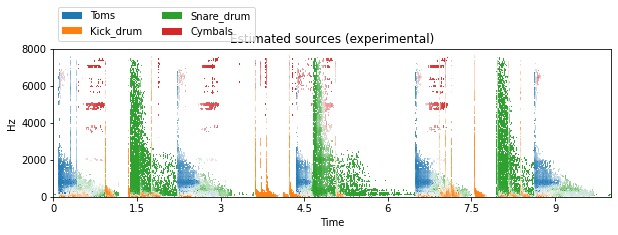


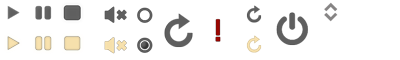
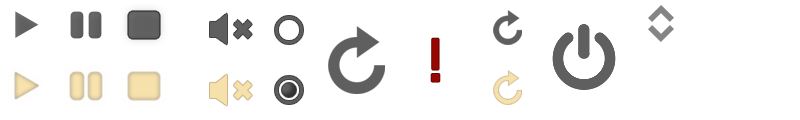
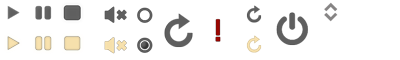

Experimental: {'combination': (0, 1, 2, 3), 'permutation': (3, 0, 1, 2), 'Cymbals': [1.2115962807432814], 'Kick_drum': [4.53576614517512], 'Snare_drum': [2.1908953457656515], 'Toms': [4.7483028752281795]}


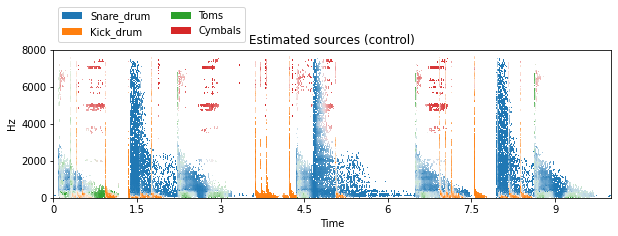


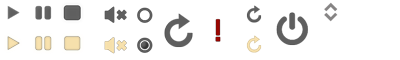
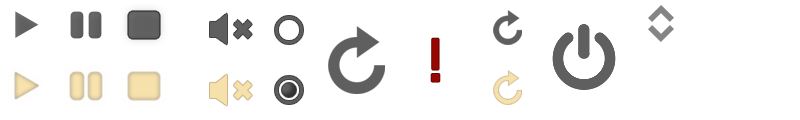
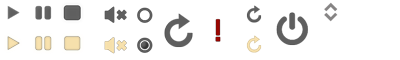

Control: {'combination': (0, 1, 2, 3), 'permutation': (3, 0, 1, 2), 'Cymbals': [0.7505875490432532], 'Kick_drum': [8.407068465105835], 'Snare_drum': [-4.089361496412004], 'Toms': [3.153475869642528]}


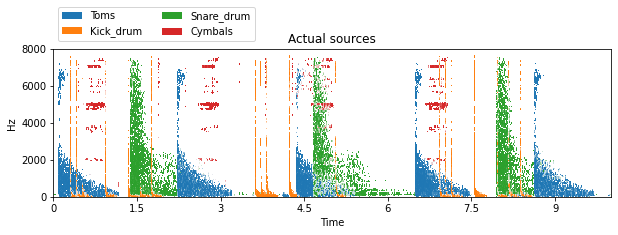


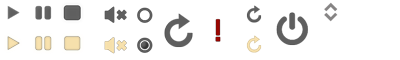
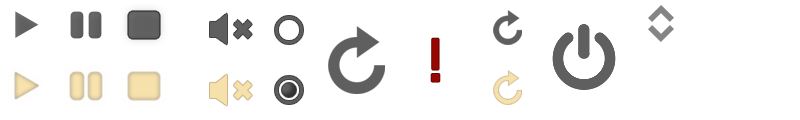
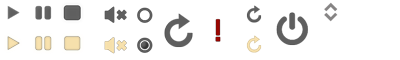

In [27]:
item = drumset_dataset[0]
source_keys = sorted(item["sources"].keys())
exp_ests = drumset_exp_sep(audio_signal=item["mix"])
control_ests = drumset_control_sep(audio_signal=item["mix"])
visualize_and_embed({s: est for s, est in zip(source_keys, exp_ests)}, 
                    label="Estimated sources (experimental)")
print("Experimental: " + str(evaluate(item, exp_ests)))

visualize_and_embed({s: est for s, est in zip(source_keys, control_ests)},
                    label="Estimated sources (control)")
print("Control: " + str(evaluate(item, control_ests)))
visualize_and_embed(item["sources"], label="Actual sources")

## Downstream 3: Bach10

Control SI-SDR: `-0.20 +/-  2.11`


Best Experimental SI-SDR: `0.26 +/-  2.03`

In [50]:
## Dataset

bach_dataset = pipeline.dataset_prep.get_onthefly_dataset(
    "../Bach10_otf/test", "CoherentMixing",
    training=False,
    mix_length=10,
    source_types = ["violin", "clarinet", "saxphone", "bassoon"]
)


In [48]:
## Load our models
experimental_key = "bach10_exper(14)"
control_key = "bach10_control(32)"
item = bach_dataset[0]

bach_exp_sep = DeepMaskEstimation(item["mix"])
bach_control_sep = DeepMaskEstimation(item["mix"])
bach_exp_sep.__dict__.update(get_model(experimental_key).__dict__)
bach_control_sep.__dict__.update(get_model(control_key).__dict__)

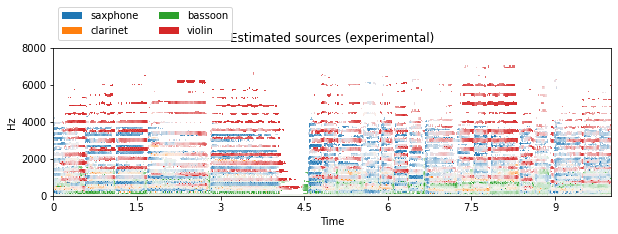


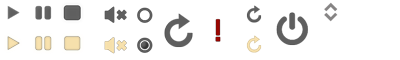
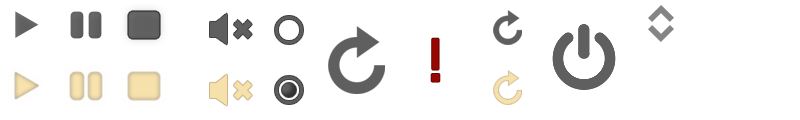
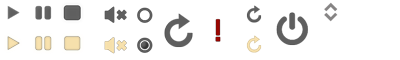

Experimental: {'combination': (0, 1, 2, 3), 'permutation': (3, 1, 2, 0), 'bassoon': [-2.5488874316215515], 'clarinet': [1.9374299049377441], 'saxphone': [1.8070785701274872], 'violin': [1.7137263715267181]}


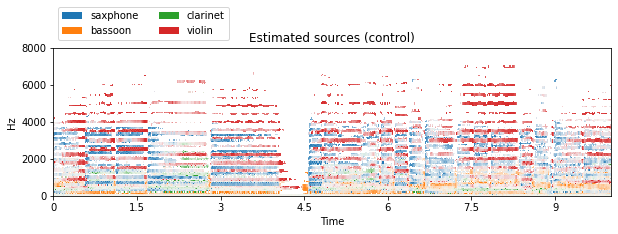


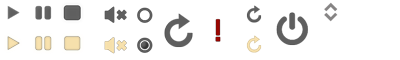
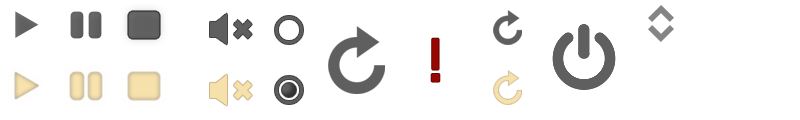
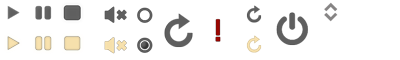

Control: {'combination': (0, 1, 2, 3), 'permutation': (3, 1, 2, 0), 'bassoon': [-2.8537198901176453], 'clarinet': [1.5550373494625092], 'saxphone': [1.1909490823745728], 'violin': [-0.01493701129220426]}


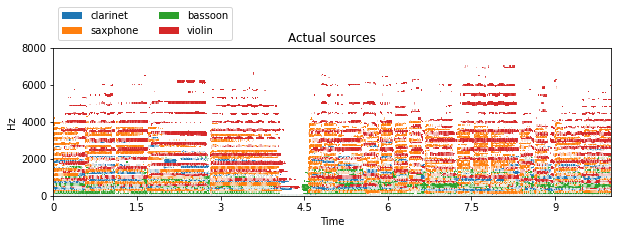


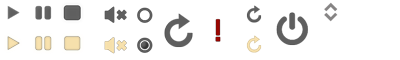
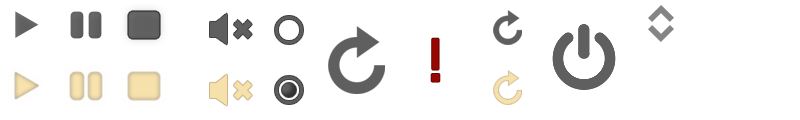
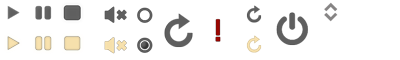

In [51]:
item = bach_dataset[0]
source_keys = sorted(item["sources"].keys())
exp_ests = bach_exp_sep(audio_signal=item["mix"])
control_ests = bach_control_sep(audio_signal=item["mix"])
visualize_and_embed({s: est for s, est in zip(source_keys, exp_ests)}, 
                    label="Estimated sources (experimental)")
print("Experimental: " + str(evaluate(item, exp_ests)))

visualize_and_embed({s: est for s, est in zip(source_keys, control_ests)},
                    label="Estimated sources (control)")
print("Control: " + str(evaluate(item, control_ests)))
visualize_and_embed(item["sources"], label="Actual sources")